Import libraries

In [59]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model      import LinearRegression
from sklearn.linear_model      import Lasso
from sklearn.model_selection   import train_test_split
from sklearn.impute            import SimpleImputer
from sklearn.preprocessing     import FunctionTransformer
from sklearn.preprocessing     import OneHotEncoder
from sklearn.preprocessing     import OrdinalEncoder
from sklearn.compose           import ColumnTransformer
from sklearn.preprocessing     import StandardScaler
from sklearn.pipeline          import Pipeline
from sklearn.decomposition     import PCA
from sklearn.tree              import DecisionTreeRegressor
from sklearn.tree              import DecisionTreeClassifier
from sklearn.neighbors         import KNeighborsRegressor
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.model_selection   import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, SelectFromModel, RFE
from sklearn.ensemble          import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.ensemble          import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics           import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.linear_model      import RidgeCV
from sklearn.svm               import SVR, LinearSVR

import pickle

### Import Dataset with +170k songs

In [5]:
df = pd.read_csv("kaggle_data.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174389 entries, 0 to 174388
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      174389 non-null  float64
 1   artists           174389 non-null  object 
 2   danceability      174389 non-null  float64
 3   duration_ms       174389 non-null  int64  
 4   energy            174389 non-null  float64
 5   explicit          174389 non-null  int64  
 6   id                174389 non-null  object 
 7   instrumentalness  174389 non-null  float64
 8   key               174389 non-null  int64  
 9   liveness          174389 non-null  float64
 10  loudness          174389 non-null  float64
 11  mode              174389 non-null  int64  
 12  name              174389 non-null  object 
 13  popularity        174389 non-null  int64  
 14  release_date      174389 non-null  object 
 15  speechiness       174389 non-null  float64
 16  tempo             17

### Data Cleaning

Drop categorical columns that contain single values

In [7]:
df.drop(columns=['name', 'artists', 'id'], inplace=True)

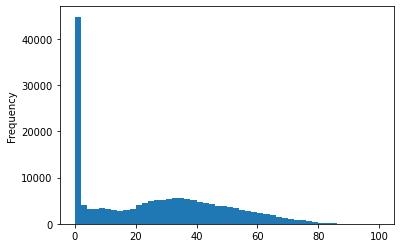

In [8]:
df['popularity'].plot.hist(bins=50)

In [9]:
(df['popularity'].value_counts()[0] / len(df))*100

23.45618129583861

23% of the songs have a popularity of 0

Get the correlation of each parameter with the "Popularity"

In [10]:
corr_matrix = df.corr()

In [11]:
corr_matrix['popularity'].sort_values(ascending=False)

popularity          1.000000
year                0.513227
loudness            0.337194
energy              0.328939
explicit            0.152545
danceability        0.123746
tempo               0.094985
valence             0.063471
duration_ms         0.024717
mode                0.007652
key                 0.001951
liveness           -0.078959
speechiness        -0.195329
instrumentalness   -0.300625
acousticness       -0.396744
Name: popularity, dtype: float64

Transform the 'release_date' column to Data format

In [12]:
df['release_date'] = pd.to_datetime(df['release_date'])

In [13]:
df['month'] = df['release_date'].dt.month

In [14]:
df['month'].value_counts()

1     90183
12    15399
11    10258
10     8469
9      7676
6      7131
5      6343
3      6339
8      6153
7      5852
4      5553
2      5033
Name: month, dtype: int64

We drop the columns 'release_date' and 'month' as more than 50% of dates only contain the year.

In [15]:
df.drop(columns=['release_date', 'month'], inplace=True)

Transform 'key' column to str in order to make the Hot Encoding

In [16]:
df['key'] = df['key'].apply(str)

Split data to start training our models

In [17]:
X = df.drop(columns='popularity').copy()
y = df['popularity'].copy()

In [18]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(exclude=["int64", "float64"]).columns

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [20]:
def fill_numeric_nulls(df):
    imputer = SimpleImputer(strategy="median")
    X = imputer.fit_transform(df)
    return X

numeric_nulls_imputer = FunctionTransformer(fill_numeric_nulls)

In [21]:
inter_pipeline = ColumnTransformer([
    ("onehot_enc", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num_nulls_imp", numeric_nulls_imputer, num_cols) 
])

In [22]:
feature_selector_dtree = SelectFromModel(DecisionTreeRegressor(), max_features=7)

Pipeline with Linear Regression Model

0.8  -->  0.27364671377710403
0.81  -->  0.27364671377710403
0.8200000000000001  -->  0.27364671377710403
0.8300000000000001  -->  0.30324929410485
0.8400000000000001  -->  0.30324929410485
0.8500000000000001  -->  0.30324929410485
0.8600000000000001  -->  0.30324929410485
0.8700000000000001  -->  0.30962484596715245
0.8800000000000001  -->  0.30962484596715245
0.8900000000000001  -->  0.30962484596715245
0.9000000000000001  -->  0.3133293877013281
0.9100000000000001  -->  0.3133293877013281
0.9200000000000002  -->  0.3133293877013281
0.9300000000000002  -->  0.31337894105622666
0.9400000000000002  -->  0.31337894105622666
0.9500000000000002  -->  0.3456705574116876
0.9600000000000002  -->  0.3456705574116876
0.9700000000000002  -->  0.3456705574116876
0.9800000000000002  -->  0.3611972833108643
0.9900000000000002  -->  0.36477232822113936


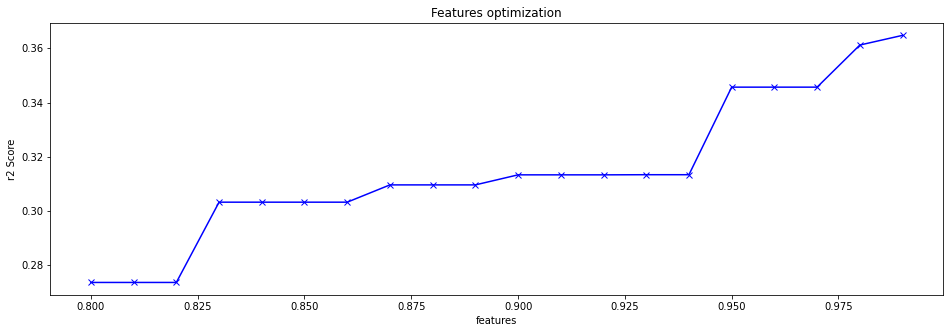

In [23]:
K = np.arange(0.8, 0.999, 0.01)
rmse = []
for k in K:
    pipeline_reg = Pipeline([
        ("intermediate_pipe", inter_pipeline),
        ("standard_scal", StandardScaler()),
        #("feature_select", SelectFromModel(DecisionTreeRegressor(), max_features=k)),
        ("pca", PCA(n_components=k)),
        ("reg", LinearRegression())
    ])
    pipeline_reg.fit(X_train, y_train)
    y_pred = pipeline_reg.predict(X_test)
    rmse.append(r2_score(y_test, y_pred))
    print(str(k), " --> ", str(r2_score(y_test, y_pred)))
    
# plot
plt.figure(figsize=(16,5))
plt.plot(K, rmse, 'bx-')
plt.xlabel('features')
plt.ylabel('r2 Score')
plt.title('Features optimization')
plt.savefig('features_opti.png', transparent=True)

In [24]:
pipeline_reg = Pipeline([
    ("intermediate_pipe", inter_pipeline),
    ("standard_scal", StandardScaler()),
    #("feature_select", feature_selector_dtree),
    ("pca", PCA(n_components=0.95)),
    ("reg", LinearRegression())
])

In [25]:
pipeline_reg.fit(X_train, y_train)
y_pred_reg = pipeline_reg.predict(X_test)
print('reg', r2_score(y_test, y_pred_reg))

reg 0.3456705574116876


Pipeline with Lasso Regression Model

In [26]:
pipeline_lasso = Pipeline([
    ("intermediate_pipe", inter_pipeline),
    ("standard_scal", StandardScaler()),
    #("feature_select", feature_selector_dtree),
    ("pca", PCA(n_components=0.95)),
    ("lasso", Lasso(alpha=0.05))
])

In [27]:
pipeline_lasso.fit(X_train, y_train)
y_pred_lasso = pipeline_lasso.predict(X_test)
print('lasso', r2_score(y_test, y_pred_lasso))

lasso 0.34547837511050405


Pipeline with Epsilon-Support Vector Regression

0.05  -->  0.2725380568593678
0.1  -->  0.27169264952755867
0.15000000000000002  -->  0.27210170265570355
0.2  -->  0.2700987563563818
0.25  -->  0.27155911516577835
0.3  -->  0.27059133394580703
0.35000000000000003  -->  0.27144944178411445
0.4  -->  0.2719011740392464
0.45  -->  0.2719710822021547
0.5  -->  0.2714382066611827
0.55  -->  0.271315738331421
0.6000000000000001  -->  0.2707647607765088
0.6500000000000001  -->  0.27080303135331274
0.7000000000000001  -->  0.27148374787107643
0.7500000000000001  -->  0.27131618753426834
0.8  -->  0.27150930861974343
0.8500000000000001  -->  0.27152634387533736
0.9000000000000001  -->  0.27171340373557273


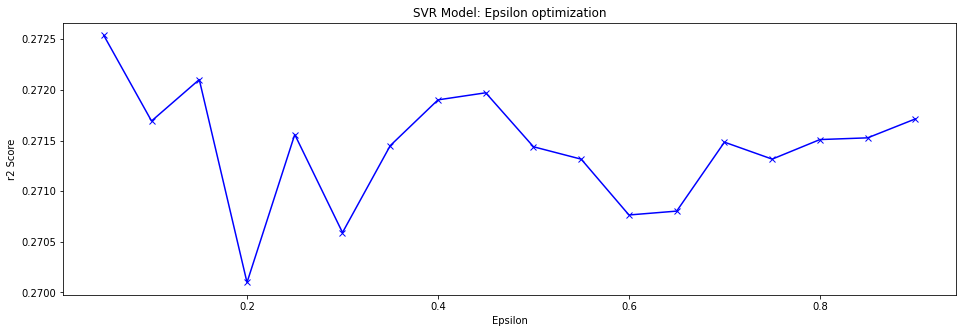

In [29]:
K = np.arange(0.05, 0.95, 0.05)
rmse = []
for k in K:
    pipeline_svr = Pipeline([
        ("intermediate_pipe", inter_pipeline),
        ("standard_scal", StandardScaler()),
        #("feature_select", feature_selector_dtree),
        ("pca", PCA(n_components=0.95)),
        ("svr", LinearSVR(C=1, epsilon=k))
    ])
    pipeline_svr.fit(X_train, y_train)
    y_pred = pipeline_svr.predict(X_test)
    rmse.append(r2_score(y_test, y_pred))
    print(str(k), " --> ", str(r2_score(y_test, y_pred)))
    
# plot
# plot
plt.figure(figsize=(16,5))
plt.plot(K, rmse, 'bx-')
plt.xlabel('Epsilon')
plt.ylabel('r2 Score')
plt.title('SVR Model: Epsilon optimization')
plt.savefig('svr_model.png', transparent=True)

In [30]:
pipeline_svr = Pipeline([
    ("intermediate_pipe", inter_pipeline),
    ("standard_scal", StandardScaler()),
    #("feature_select", feature_selector_dtree),
    ("pca", PCA(n_components=0.95)),
    ("svr", LinearSVR(C=1.0, epsilon=0.4))
])

In [31]:
pipeline_svr.fit(X_train, y_train)
y_pred_svr = pipeline_svr.predict(X_test)
print('svr', r2_score(y_test, y_pred_svr))

svr 0.2713076184089668


Pipeline with k-nearest Neighbors Regression

10  -->  0.5263823985910525
20  -->  0.5391501503830924
30  -->  0.5392977494192974
40  -->  0.5382726126208179
50  -->  0.5356108229575235
60  -->  0.532869112498695
70  -->  0.5310401352215539
80  -->  0.529302543789395
90  -->  0.5270660592038231


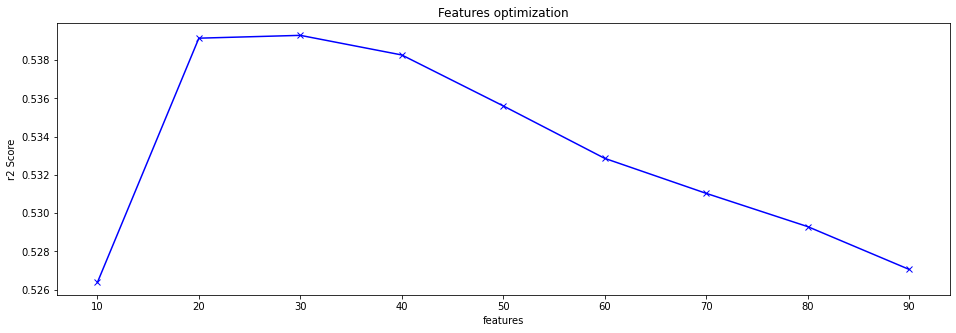

In [39]:
K = np.arange(10, 100, 10)
rmse = []
for k in K:
    pipeline_neigh = Pipeline([
        ("intermediate_pipe", inter_pipeline),
        ("standard_scal", StandardScaler()),
        #("feature_select", feature_selector_dtree),
        ("pca", PCA(n_components=0.95)),
        ("neigh", KNeighborsRegressor(n_neighbors=k, weights = 'distance', p=1))
    ])
    pipeline_neigh.fit(X_train, y_train)
    y_pred = pipeline_neigh.predict(X_test)
    rmse.append(r2_score(y_test, y_pred))
    print(str(k), " --> ", str(r2_score(y_test, y_pred)))
    
# plot
plt.figure(figsize=(16,5))
plt.plot(K, rmse, 'bx-')
plt.xlabel('features')
plt.ylabel('r2 Score')
plt.title('Features optimization')
plt.savefig('features_opti.png', transparent=True)

In [40]:
pipeline_neigh = Pipeline([
    ("intermediate_pipe", inter_pipeline),
    ("standard_scal", StandardScaler()),
    #("feature_select", feature_selector_dtree),
    ("pca", PCA(n_components=0.95)),
    ("neigh", KNeighborsRegressor(n_neighbors=35, weights = 'distance', p=1))
])

In [41]:
pipeline_neigh.fit(X_train, y_train)
y_pred_neigh = pipeline_neigh.predict(X_test)
print('neigh', r2_score(y_test, y_pred_neigh))

neigh 0.5387918182482716


Pipeline with Decision Tree Regression Model

In [42]:
pipeline_dec_tree = Pipeline([
    ("intermediate_pipe", inter_pipeline),
    ("standard_scal", StandardScaler()),
    #("feature_select", feature_selector_dtree),
    ("pca", PCA(n_components=0.95)),
    ("dec_tree", DecisionTreeRegressor(random_state=0))
])

In [43]:
pipeline_dec_tree.fit(X_train, y_train)
y_pred_dec_tree = pipeline_dec_tree.predict(X_test)
print('dec_tree', r2_score(y_test, y_pred_dec_tree))

dec_tree 0.15451257875786206


Pipeline with Random Forest Regression Model

In [44]:
pipeline_rfr = Pipeline([
    ("intermediate_pipe", inter_pipeline),
    ("standard_scal", StandardScaler()),
    #("feature_select", feature_selector_dtree),
    #("pca", PCA(n_components=0.95)),
    ("rfr", RandomForestRegressor(n_estimators=170, random_state=0))
])

In [45]:
pipeline_rfr.fit(X_train, y_train)
y_pred_rfr = pipeline_rfr.predict(X_test)
print('rfr', r2_score(y_test, y_pred_rfr))

rfr 0.6933349271670435


Pipeline with ADA Boost Regression Model

In [46]:
pipeline_ada = Pipeline([
    ("intermediate_pipe", inter_pipeline),
    ("standard_scal", StandardScaler()),
    #("feature_select", feature_selector_dtree),
    #("pca", PCA(n_components=0.95)),
    ("ada", AdaBoostRegressor(n_estimators=100, random_state=0))
])

In [47]:
pipeline_ada.fit(X_train, y_train)
y_pred_ada = pipeline_ada.predict(X_test)
print('ada', r2_score(y_test, y_pred_ada))

ada 0.46920768429081194


Pipeline with Gradient Boost Regression Model

In [48]:
pipeline_grad = Pipeline([
    ("intermediate_pipe", inter_pipeline),
    ("standard_scal", StandardScaler()),
    #("feature_select", feature_selector_dtree),
    #("pca", PCA(n_components=0.95)),
    ("grad", GradientBoostingRegressor(n_estimators=230, random_state=0))
])

In [49]:
pipeline_grad.fit(X_train, y_train)
y_pred_grad = pipeline_grad.predict(X_test)
print('grad', r2_score(y_test, y_pred_grad))

grad 0.6327939180371589


Stacking Regressor using the best 3 models: K-nearest neighboors, Random Forest and Gradient Boosting

In [51]:
estimators = [('neigh', pipeline_neigh),
              ('rfr', pipeline_rfr),
              ('grad', pipeline_grad)
             ]

In [52]:
stacking_regressor = StackingRegressor(estimators=estimators)

In [31]:
pipeline_neigh.fit(X_train, y_train)
pipeline_rfr.fit(X_train, y_train)
pipeline_grad.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('intermediate_pipe',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehot_enc',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  Index(['key'], dtype='object')),
                                                 ('num_nulls_imp',
                                                  FunctionTransformer(acce...
                                           l

In [32]:
y_pred_neigh    = pipeline_neigh.predict(X_test)
y_pred_rfr      = pipeline_rfr.predict(X_test)
y_pred_grad     = pipeline_grad.predict(X_test)

In [50]:
print('neigh   ', r2_score(y_test, y_pred_neigh))
print('rfr     ', r2_score(y_test, y_pred_rfr))
print('grad    ', r2_score(y_test, y_pred_grad))

neigh    0.5387918182482716
rfr      0.6933349271670435
grad     0.6327939180371589


In [53]:
stacking_regressor.fit(X_train, y_train)

StackingRegressor(cv=None,
                  estimators=[('neigh',
                               Pipeline(memory=None,
                                        steps=[('intermediate_pipe',
                                                ColumnTransformer(n_jobs=None,
                                                                  remainder='drop',
                                                                  sparse_threshold=0.3,
                                                                  transformer_weights=None,
                                                                  transformers=[('onehot_enc',
                                                                                 OneHotEncoder(categories='auto',
                                                                                               drop=None,
                                                                                               dtype=<class 'numpy.float64'>,
                           

In [54]:
y_pred_stack    = stacking_regressor.predict(X_test)

In [61]:
print('r2_score:', r2_score(y_test, y_pred_stack))
print('mae     :', mean_absolute_error(y_test, y_pred_stack))
print('mse     :', mean_squared_error(y_test, y_pred_stack))
print('rmse    :', mean_squared_error(y_test, y_pred_stack, squared=False))
print('mdae    :', median_absolute_error(y_test, y_pred_stack))

r2_score: 0.6935535485689012
mae     : 8.133411289036747
mse     : 148.38505382710318
rmse    : 12.181340395338404
mdae    : 5.45290401000792


Save models

In [57]:
pickle.dump(pipeline_reg, open('pipeline_reg.sav', 'wb'))
pickle.dump(pipeline_lasso, open('pipeline_lasso.sav', 'wb'))
pickle.dump(pipeline_svr, open('pipeline_svr.sav', 'wb'))
pickle.dump(pipeline_neigh, open('pipeline_neigh.sav', 'wb'))
pickle.dump(pipeline_dec_tree, open('pipeline_dec_tree.sav', 'wb'))
pickle.dump(pipeline_rfr, open('pipeline_rfr.sav', 'wb'))
pickle.dump(pipeline_ada, open('pipeline_ada.sav', 'wb'))
pickle.dump(pipeline_grad, open('pipeline_grad.sav', 'wb'))
pickle.dump(stacking_regressor, open('stacking_regressor.sav', 'wb'))

Validate model

In [76]:
df_validation = pd.read_csv('songs_lyrics_complete.csv')

In [77]:
df_validation.drop(columns=['name', 'artist_1', 'artist_2', 'uri', 'lyrics'], inplace=True)

In [78]:
df_validation['key'] = df_validation['key'].apply(str)

In [79]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174389 entries, 0 to 174388
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      174389 non-null  float64
 1   danceability      174389 non-null  float64
 2   duration_ms       174389 non-null  int64  
 3   energy            174389 non-null  float64
 4   explicit          174389 non-null  int64  
 5   instrumentalness  174389 non-null  float64
 6   key               174389 non-null  object 
 7   liveness          174389 non-null  float64
 8   loudness          174389 non-null  float64
 9   mode              174389 non-null  int64  
 10  speechiness       174389 non-null  float64
 11  tempo             174389 non-null  float64
 12  valence           174389 non-null  float64
 13  year              174389 non-null  int64  
dtypes: float64(9), int64(4), object(1)
memory usage: 18.6+ MB


In [80]:
X_val = df_validation.drop(columns='popularity').copy()
y_val = df_validation['popularity'].copy()

In [81]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4272 entries, 0 to 4271
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              4272 non-null   int64  
 1   explicit          4272 non-null   bool   
 2   duration_ms       4272 non-null   int64  
 3   danceability      4272 non-null   float64
 4   energy            4272 non-null   float64
 5   key               4272 non-null   object 
 6   loudness          4272 non-null   float64
 7   mode              4272 non-null   int64  
 8   speechiness       4272 non-null   float64
 9   acousticness      4272 non-null   float64
 10  instrumentalness  4272 non-null   float64
 11  liveness          4272 non-null   float64
 12  valence           4272 non-null   float64
 13  tempo             4272 non-null   float64
dtypes: bool(1), float64(9), int64(3), object(1)
memory usage: 438.2+ KB


In [84]:
X_val = X_val[list(X.columns.values)]

In [85]:
y_pred_val = stacking_regressor.predict(X_val)

In [86]:
print('r2_score:', r2_score(y_val, y_pred_val))
print('mae     :', mean_absolute_error(y_val, y_pred_val))
print('mse     :', mean_squared_error(y_val, y_pred_val))
print('rmse    :', mean_squared_error(y_val, y_pred_val, squared=False))
print('mdae    :', median_absolute_error(y_val, y_pred_val))

r2_score: 0.1240888846487439
mae     : 16.03363215649902
mse     : 542.6863547025782
rmse    : 23.295629519345002
mdae    : 9.312849728251543
